# Accessing S3 via PySpark - Same image is different - Spark vs Local

In [1]:
from PIL import Image
import numpy as np

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
15,application_1649886739542_0019,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
src_img_path = "s3://multimedia-commons/data/images/000/24a/00024a73d1a4c32fb29732d56a2.jpg"

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Reading file as binary gives different size than the image

In [3]:
# https://sparkbyexamples.com/spark/spark-read-binary-file-into-dataframe/
df = spark.read.format("binaryFile").load(src_img_path)
df.printSchema()
df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|s3://multimedia-c...|2019-03-31 01:07:42| 40382|[FF D8 FF E0 00 1...|
+--------------------+-------------------+------+--------------------+

In [4]:
# https://stackoverflow.com/questions/58611888/how-is-spark-reading-my-image-using-the-image-format
df = spark.read.format("image").load(src_img_path)
df.printSchema()
df.select("image.height","image.width","image.nChannels", "image.mode", "image.data").show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)

+------+-----+---------+----+--------------------+
|height|width|nChannels|mode|                data|
+------+-----+---------+----+--------------------+
|   260|  500|        3|  16|[00 00 00 00 00 0...|
+------+-----+---------+----+--------------------+

In [5]:
#img_bytes = df.select("image.data").take(1)
img_bytes = df.select("image.data").first()
len(img_bytes)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1

In [6]:
len(img_bytes[0])  # Should be 40382  

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

390000

## Display pixels of the image from Spark

In [7]:
img_ba = img_bytes[0]
img_b = bytes(img_ba)
# https://stackoverflow.com/a/50026948/11262633
img_pil = Image.frombytes('RGB', (260,500), img_b, 'raw')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
img_np = np.asarray(img_pil)
img_np.shape

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(500, 260, 3)

In [29]:
def disp_pixels(img_np):
    m = np.ma.masked_greater(img_np, 100)
    m_mask = m.mask

    args = np.argwhere(m_mask)

#     for idx, (r, c, _) in enumerate(args):
#         print(r, c, img_np[r,c])
#         if idx > 5:
#             break    
    r = 47
    for c in range(104,111):
        print(r, c, img_np[r,c])
        

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
%%spark -o df_local
# Per https://stackoverflow.com/a/57863292/11262633
df_local = df

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

odict_keys(['origin', 'height', 'width', 'nChannels', 'mode', 'data'])
260 500 16


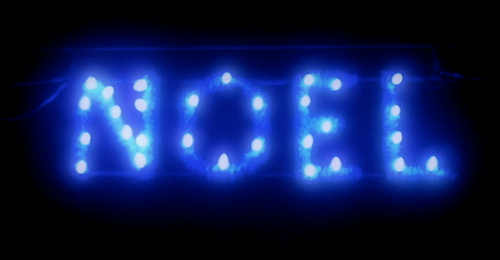

In [11]:
%%local
from IPython.display import display
#from PIL import Image
import io, base64
from PIL import Image

#%matplotlib inline
img_dict = df_local['image'].iloc[0]
print(img_dict.keys())
h = img_dict['height']
w = img_dict['width']
spark_mode = img_dict['mode']
img_str = img_dict['data']
print(h, w, spark_mode)
# print(len(img_str))
# print(type(img_str))
# print(img_str[-100:])

# Assuming base64_str is the string value without 'data:image/jpeg;base64,'
# https://stackoverflow.com/questions/2323128/convert-string-in-base64-to-image-and-save-on-filesystem
img_b = bytes(img_str, "utf-8")
img_base64 = base64.decodebytes(img_b)
mode = 'RGB'
img = Image.frombytes(mode, (w, h), img_base64, 'raw')
img


In [30]:
disp_pixels(img_np)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

47 104 [  1.  15. 102.]
47 105 [  1.  16. 104.]
47 106 [  1.  16. 104.]
47 107 [  1.  16. 104.]
47 108 [  1.  16. 104.]
47 109 [  1.  15. 105.]
47 110 [  2.  16. 106.]

## The same pixels from the local image

47 104 [101  16   9]
47 105 [103  16   9]
47 106 [103  16   9]
47 107 [103  16   9]
47 108 [103  16   9]
47 109 [104  15   9]
47 110 [105  16  10]


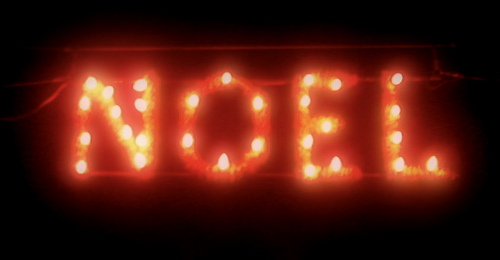

In [26]:
%%local
import numpy as np
img_local = Image.open('/home/emr-notebook/00024a73d1a4c32fb29732d56a2.jpg')
img_np_local = np.asarray(img_local)
m_local = np.ma.masked_greater(img_np_local, 100)
m_mask_local = m_local.mask

args_local = np.argwhere(m_mask_local)

for idx, (r, c, _) in enumerate(args_local):
    print(r, c, img_np_local[r,c])
    if idx > 5:
        break    
img_local

## Use the built-in ```toNDArray``` function

In [14]:
# https://stackoverflow.com/a/69215982/11262633
import pyspark.sql.functions as F
from pyspark.ml.image import ImageSchema
from pyspark.ml.linalg import DenseVector, VectorUDT

img2vec = F.udf(lambda x: DenseVector(ImageSchema.toNDArray(x).flatten()), VectorUDT())

print(f'Image fields = {ImageSchema.imageFields}')
df_new = df.withColumn('vecs',img2vec('image'))
df_new.show()
#df_new.select('vecs').first().asDict().keys()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Image fields = ['origin', 'height', 'width', 'nChannels', 'mode', 'data']
+--------------------+--------------------+
|               image|                vecs|
+--------------------+--------------------+
|{s3://multimedia-...|[0.0,0.0,0.0,0.0,...|
+--------------------+--------------------+

In [15]:
row_dict = df_new.first().asDict()
img_vec = row_dict['vecs']
print(img_vec.shape, type(img_vec))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(390000,) <class 'pyspark.ml.linalg.DenseVector'>

In [16]:
img_dict = row_dict['image']
type(img_dict)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pyspark.sql.types.Row'>

In [17]:
for f in ImageSchema.imageFields:
    if f == 'data':
        continue
    print(f, img_dict[f])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

origin s3://multimedia-commons/data/images/000/24a/00024a73d1a4c32fb29732d56a2.jpg
height 260
width 500
nChannels 3
mode 16

In [18]:
width = img_dict['width']
height = img_dict['height']
nChannels = img_dict['nChannels']

img_np = img_vec.reshape(height, width, nChannels)

# img_np = np.ndarray(
#             shape=(height, width, nChannels),
#             dtype=np.uint8,
#             buffer=img_dict['data'],
#             strides=(width * nChannels, nChannels, 1))
# img_np[47,106] # Gives [1, 16, 104].  Need [103,  16,   9]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [31]:
disp_pixels(img_np)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

47 104 [  1.  15. 102.]
47 105 [  1.  16. 104.]
47 106 [  1.  16. 104.]
47 107 [  1.  16. 104.]
47 108 [  1.  16. 104.]
47 109 [  1.  15. 105.]
47 110 [  2.  16. 106.]

In [43]:
%%spark -o df_for_local
# Per https://stackoverflow.com/a/57863292/11262633
df_for_local = df_new

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(500, 260)


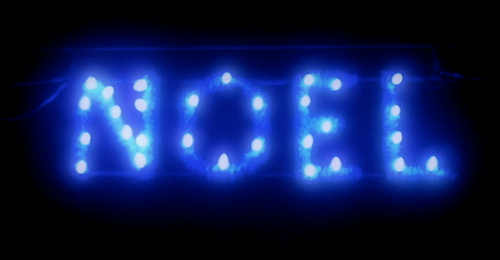

after img.show


In [44]:
%%local 
from PIL import Image
from io import StringIO
import numpy as np
#from io import BytesIO

#from matplotlib import pyplot as plt

#print(df_for_local.columns)  #['image', 'vecs', 'len'],
row = df_for_local.iloc[0]
h = row['image']['height']
w = row['image']['width']
c = row['image']['nChannels']
#print(h,w,type(h),type(w))

vec = row['vecs']
img_np = np.array(vec['values']).reshape(h,w,c).astype(np.uint8)
img = Image.fromarray(img_np)
print(img.size)
#print(type(vec))
#img_np = np.asarray(Image.open(StringIO(img_np)))
#plt.imshow(img_np)
#img = Image.fromarray(img_np)

# https://stackoverflow.com/a/26649884/11262633
display(img)
print('after img.show')

#img = Image.open(

## Use ```np.asarray``` on the Spark row

In [32]:
getLen = F.udf(lambda x:len(x))
df_with_len = df_new.withColumn('len',getLen('vecs'))
df_with_len.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+------+
|               image|                vecs|   len|
+--------------------+--------------------+------+
|{s3://multimedia-...|[0.0,0.0,0.0,0.0,...|390000|
+--------------------+--------------------+------+

In [33]:
first = df.select('image.data').first()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [34]:
import numpy as np
first_dict = first.asDict()
img_np_from_data = np.asarray(first_dict['data'])
np.histogram(img_np_from_data)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(array([251543,  35427,  24677,  15188,  10118,  10273,   9756,   9747,
        12729,  10542]), array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
       229.5, 255. ]))

In [35]:
img_np_from_data.shape, len(img_np_from_data)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

((390000,), 390000)

In [36]:
set(img_np_from_data)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [38]:
img_np = img_np_from_data.reshape(260,500,3)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [39]:
disp_pixels(img_np)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

47 104 [  1  15 102]
47 105 [  1  16 104]
47 106 [  1  16 104]
47 107 [  1  16 104]
47 108 [  1  16 104]
47 109 [  1  15 105]
47 110 [  2  16 106]

## Use TensorFlow utilities

In [118]:
#%%local
#https://stackoverflow.com/questions/66207434/how-to-extract-images-from-pyspark-dataframe-to-numpy
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img

row = df_for_local.iloc[0]
img_data = row['image']['data']
img_pil = array_to_img(img_data)
img_np_tf = img_to_array(img_pil)
print(f'img_np_tf={img_np_tf.shape}')

ModuleNotFoundError: No module named 'tensorflow'